### welcome

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import mne
import scipy.io as sio
import numpy as np

In [ ]:
data = sio.loadmat("/content/drive/MyDrive/mat2mne.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])

In [ ]:
eeg_data = data['cnt'].T
n_channels = eeg_data.shape[0]
n_time_samples = eeg_data.shape[1]

print("Shape of eeg data: " + str(eeg_data.shape))
print("No. of channels: " + str(n_channels))
print("No. of samples: " + str(n_time_samples))

Shape of eeg data: (59, 190594)
No. of channels: 59
No. of samples: 190594


In [ ]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])

In [ ]:
data["mrk"]

array([[(array([[  2091,   2891,   3691,   4491,   5291,   6091,   6891,   7692,
                  8492,   9292,  10092,  10892,  11692,  12492,  13292,  16294,
                 17094,  17894,  18694,  19494,  20294,  21094,  21894,  22694,
                 23494,  24294,  25094,  25894,  26694,  27494,  30495,  31295,
                 32095,  32895,  33695,  34495,  35295,  36095,  36895,  37695,
                 38495,  39295,  40095,  40895,  41695,  44696,  45496,  46296,
                 47096,  47896,  48696,  49496,  50296,  51096,  51896,  52696,
                 53496,  54296,  55096,  55896,  58895,  59695,  60495,  61295,
                 62095,  62895,  63695,  64495,  65295,  66095,  66895,  67695,
                 68495,  69295,  70095,  73094,  73894,  74694,  75495,  76295,
                 77095,  77895,  78695,  79495,  80295,  81095,  81895,  82695,
                 83495,  84295,  87294,  88094,  88894,  89694,  90494,  91294,
                 92094,  92894,  93694,

In [ ]:
data["cnt"]

array([[  -3,   -3,   -3, ...,    2,    7,    5],
       [ -25,  -21,  -26, ...,   19,   60,   45],
       [ -34,  -15,  -52, ...,   37,  130,   98],
       ...,
       [2524, 2672, 2347, ..., 1167, 1620, 1205],
       [2561, 2706, 2385, ..., 1249, 1693, 1210],
       [2606, 2759, 2457, ..., 1366, 1838, 1263]], dtype=int16)

In [ ]:
data["nfo"].dtype

dtype([('fs', 'O'), ('classes', 'O'), ('clab', 'O'), ('xpos', 'O'), ('ypos', 'O')])

In [ ]:
info = data["nfo"]
# info["fs"]          #stores info about the sampling frequency
# info["clab"]        #stores info about the channel names
info["classes"]     #stores info about the motor imagery classes
# info["xpos"]
# info["ypos"]


array([[array([[array(['left'], dtype='<U4'), array(['foot'], dtype='<U4')]],
              dtype=object)                                                  ]],
      dtype=object)

In [ ]:
sampling_freq = info["fs"][0][0][0][0]
ch_names = [s[0] for s in info['clab'][0][0][0]]

In [ ]:
data["mrk"][0][0][0][0].shape

(200,)

In [ ]:
event_onsets  = data['mrk'][0][0][0]             #
event_codes   = data['mrk'][0][0][1]             # Array of event codes indicating different types of events in the EEG data.

labels = np.zeros((1, n_time_samples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in info["classes"][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

# digitized electrode positions
xpos = info['xpos'][0][0]
ypos = info['ypos'][0][0]

nclasses = len(cl_lab)
nevents = len(event_onsets)

In [ ]:
# Print some information
print('Shape of EEG:', eeg_data.shape)
print('Sample rate:', sampling_freq)
print('Number of channels:', n_channels)
print('Channel names:', ch_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190594)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'foot']
Number of classes: 2


The brain's response to an event usually occurs within a specific time window after the event. By focusing on a window from 0.5 to 2.5 seconds, the analysis excludes irrelevant data from before the event and long after it, making the analysis more efficient and meaningful.

In [ ]:
win = np.arange(int(0.5*sampling_freq), int(2.5*sampling_freq))
nsamples = len(win)     # The number of samples in the defined time window.

In [ ]:
trials = {}

# Loop over the classes (left, foot) for pairing each class label with a corresponding unique event code.
for cl, code in zip(cl_lab, np.unique(event_codes)):

    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]

    # Allocate memory for the trials
    trials[cl] = np.zeros((n_channels, nsamples, len(cl_onsets)))

    # Extract each trial
    for i, onset in enumerate(cl_onsets):

        # To extract a specific segment of EEG data around an event, we need to shift our predefined time window (win) so that it starts at the event onset (onset).
        # This ensures that we are capturing the EEG data from the correct time points relative to the event.
        shifted_win = win + onset

        trials[cl][:,:,i] = eeg_data[:,shifted_win]

# the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 200, 100)
Shape of trials[cl2]: (59, 200, 100)


understanding what moveaxis does

In [ ]:
arr = np.array([[1,2,3,4],[6,7,8,9],[11,22,33,44],[12,13,14,15]])
print(arr)
arr = np.moveaxis(arr,[0,1],[1,0])
arr

[[ 1  2  3  4]
 [ 6  7  8  9]
 [11 22 33 44]
 [12 13 14 15]]


array([[ 1,  6, 11, 12],
       [ 2,  7, 22, 13],
       [ 3,  8, 33, 14],
       [ 4,  9, 44, 15]])

In [ ]:
print("shape before moving axes " + str(trials[cl1].shape))
left  = np.moveaxis(trials[cl1], 2, 0)
foot = np.moveaxis(trials[cl2], 2, 0)
print("shape after moving axes " + str(left.shape))

shape before moving axes (59, 200, 100)
shape after moving axes (100, 59, 200)


In [ ]:
all_trials = np.concatenate([left, foot])

In [ ]:
# create labels
Y = np.concatenate([-np.ones(left.shape[0]),
                     np.ones(foot.shape[0])])

### MNE and preprocess

In [ ]:
import mne

In [ ]:
# Initialize an info structure
info = mne.create_info(
        ch_names = ch_names,
        ch_types = ['eeg']*n_channels,
        sfreq    = sampling_freq )

print('Event created :', info)

Event created : <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


### Layout

In [ ]:
layout_pos = np.concatenate([xpos, ypos], axis = 1)

In [ ]:
layout = mne.channels.generate_2d_layout(
    xy = layout_pos,
    ch_names=ch_names,
    name ='EEG custom layout',
    )

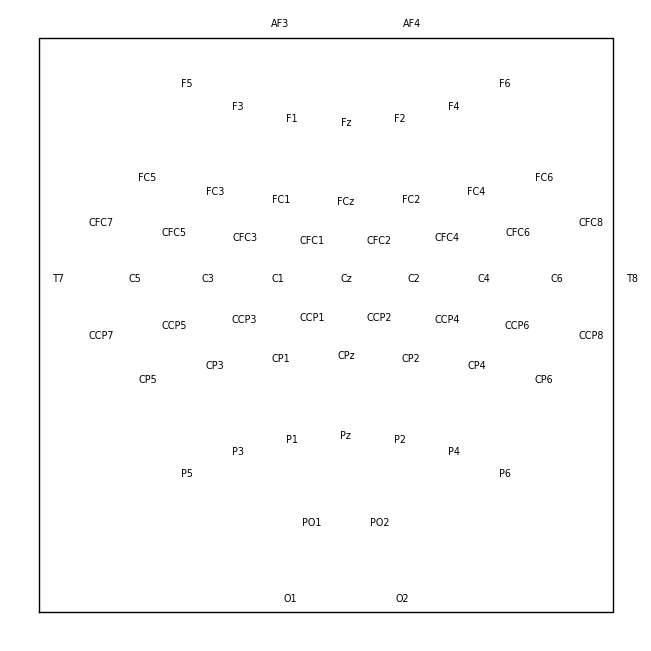

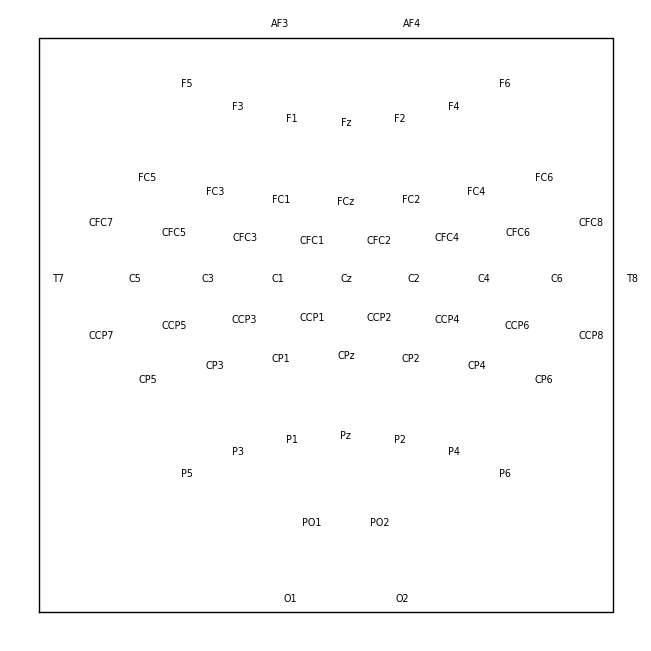

In [ ]:
layout.plot()

### events

In [ ]:
event_id = dict(left = -1, foot = 1)

In [ ]:
# Create an event matrix: events with alternating event codes
eventLength = Y.shape[0]
ev = [i*sampling_freq*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev,  dtype = int),
                          np.zeros(eventLength,  dtype = int),
                          np.array(Y,  dtype = int)))

In [ ]:
events

array([[    0,     0,    -1],
       [  300,     0,    -1],
       [  600,     0,    -1],
       [  900,     0,    -1],
       [ 1200,     0,    -1],
       [ 1500,     0,    -1],
       [ 1800,     0,    -1],
       [ 2100,     0,    -1],
       [ 2400,     0,    -1],
       [ 2700,     0,    -1],
       [ 3000,     0,    -1],
       [ 3300,     0,    -1],
       [ 3600,     0,    -1],
       [ 3900,     0,    -1],
       [ 4200,     0,    -1],
       [ 4500,     0,    -1],
       [ 4800,     0,    -1],
       [ 5100,     0,    -1],
       [ 5400,     0,    -1],
       [ 5700,     0,    -1],
       [ 6000,     0,    -1],
       [ 6300,     0,    -1],
       [ 6600,     0,    -1],
       [ 6900,     0,    -1],
       [ 7200,     0,    -1],
       [ 7500,     0,    -1],
       [ 7800,     0,    -1],
       [ 8100,     0,    -1],
       [ 8400,     0,    -1],
       [ 8700,     0,    -1],
       [ 9000,     0,    -1],
       [ 9300,     0,    -1],
       [ 9600,     0,    -1],
       [ 9

In [ ]:
event_id

{'left': -1, 'foot': 1}

In [ ]:
tmin = 0.5
epochs = mne.EpochsArray(all_trials,info,events,tmin,event_id)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
epochs.filter(l_freq=8, h_freq=32)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.5s
[Parallel(n_job

Number of events,200
Events,foot: 100left: 100
Time range,0.500 – 2.490 s
Baseline,off


### plotting RAW DATA , don't know why it is coming like that.
new

Using matplotlib as 2D backend.


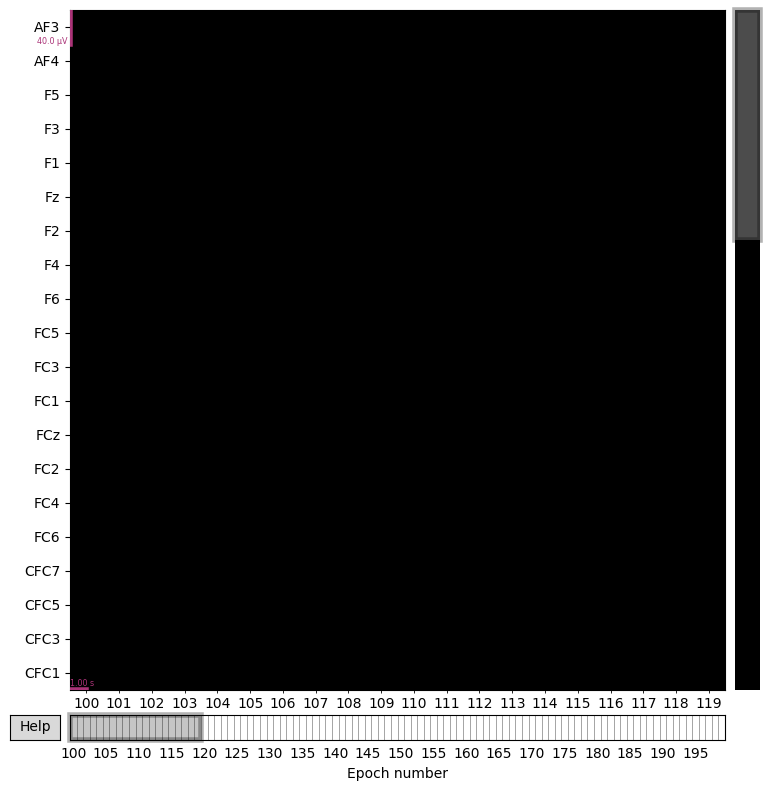

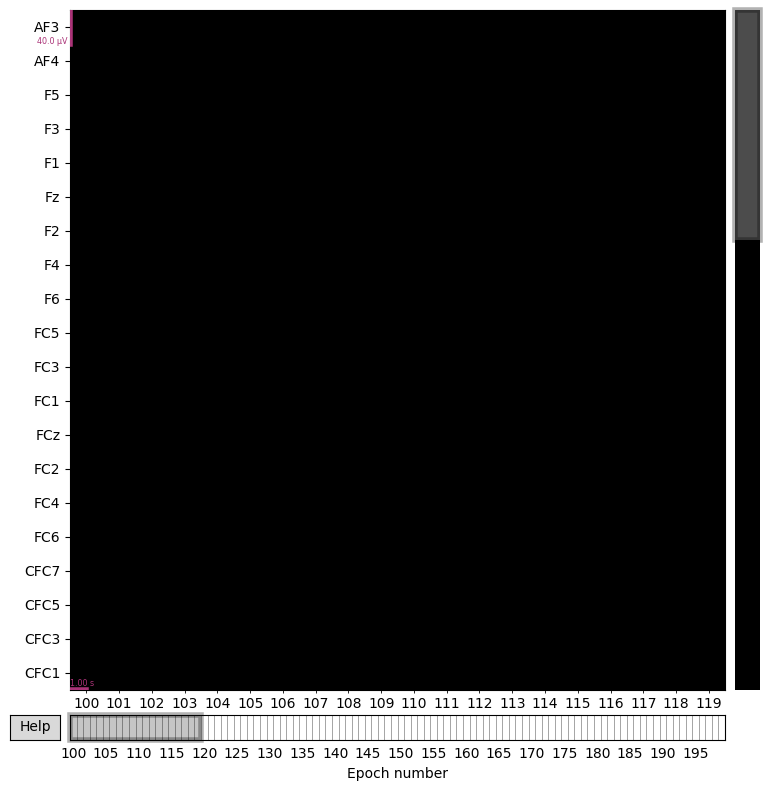

In [ ]:
epochs['foot'].plot()

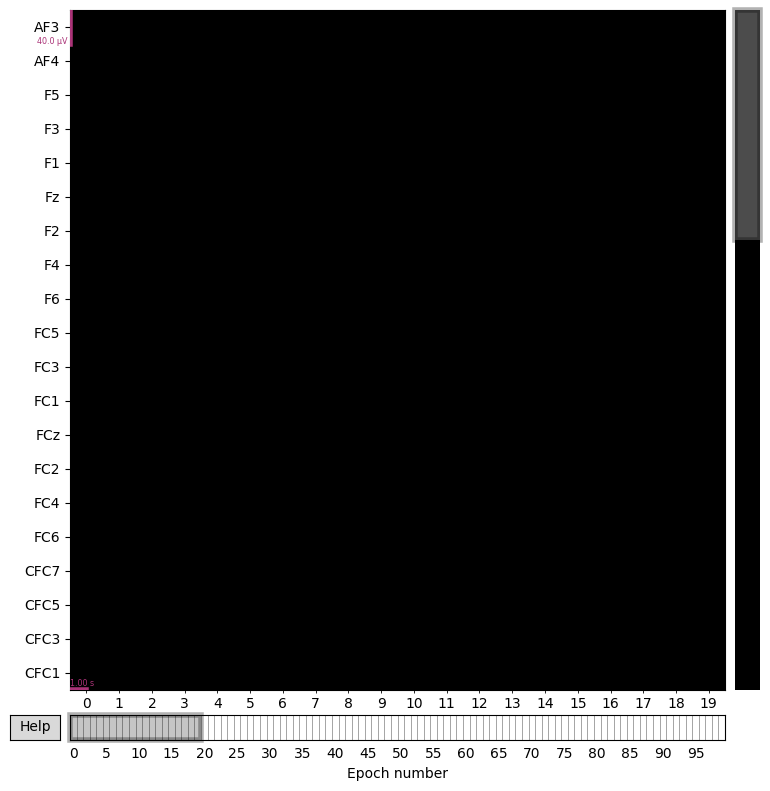

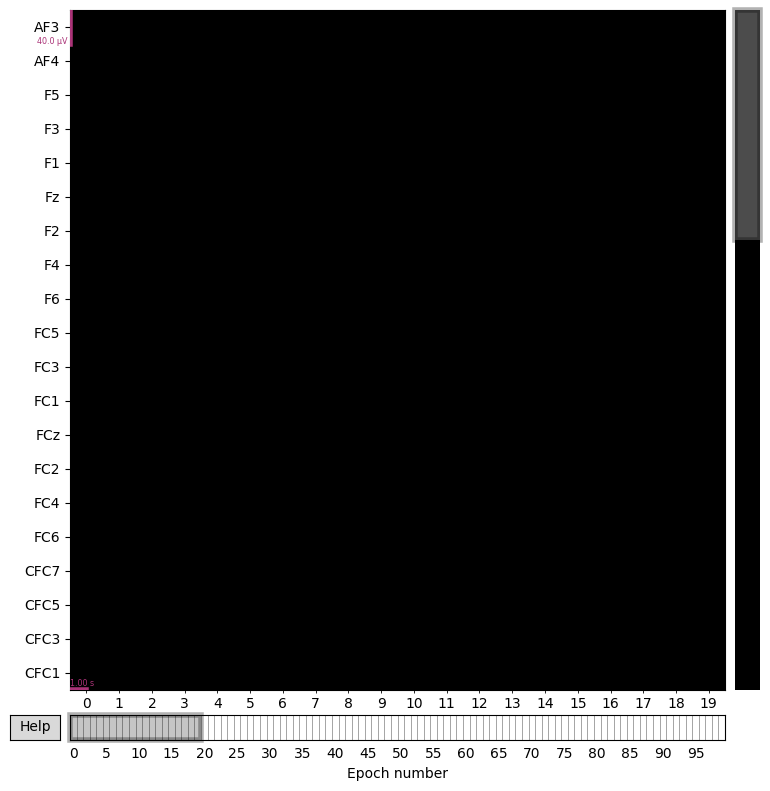

In [ ]:
epochs["left"].plot()

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)


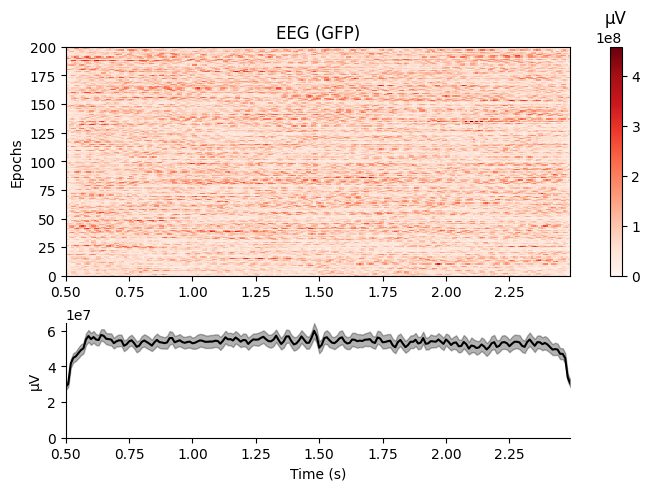

[<Figure size 640x480 with 3 Axes>]

In [ ]:
epochs.plot_image()

### PSD PLOT

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\realv\AppData\Local\Temp\ipykernel_30956\1991489676.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.plot_psd()
C:\Users\realv\AppData\Local\Temp\ipykernel_30956\1991489676.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()
c:\Users\realv\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


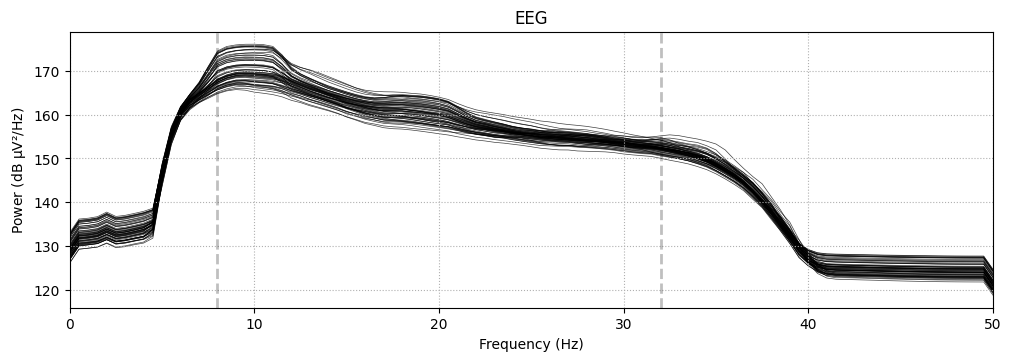

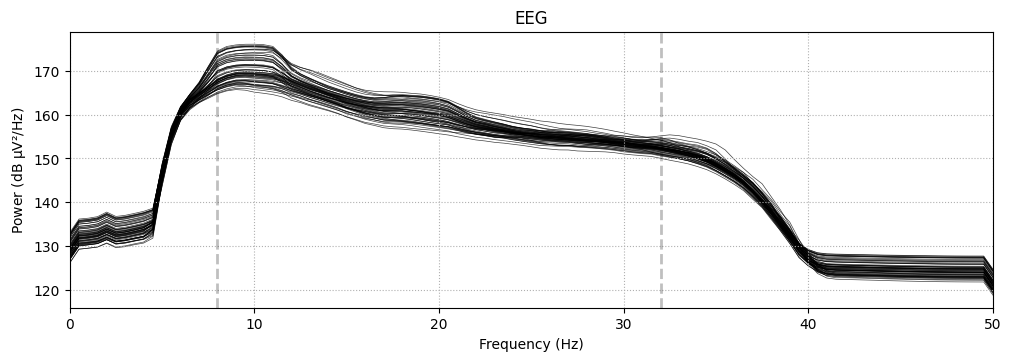

In [ ]:
epochs.plot_psd()

### Plotting ERPs using image (evoke)
new

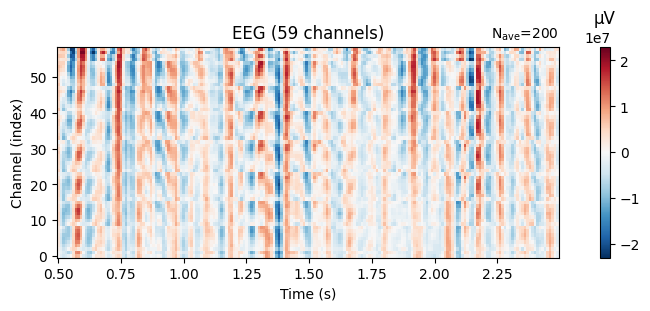

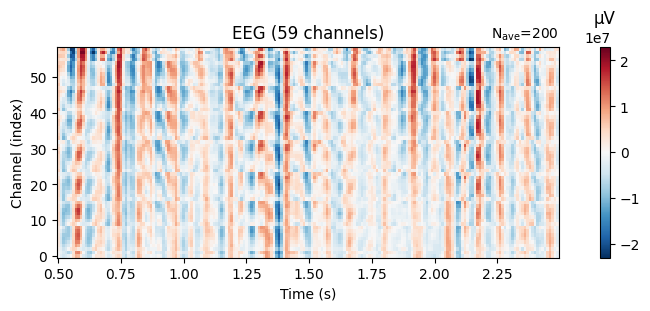

In [ ]:
epochs.average().plot_image()

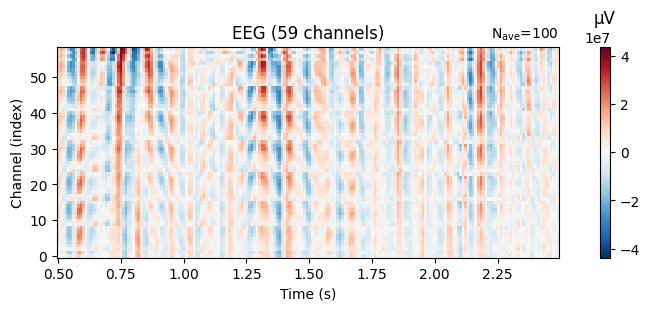

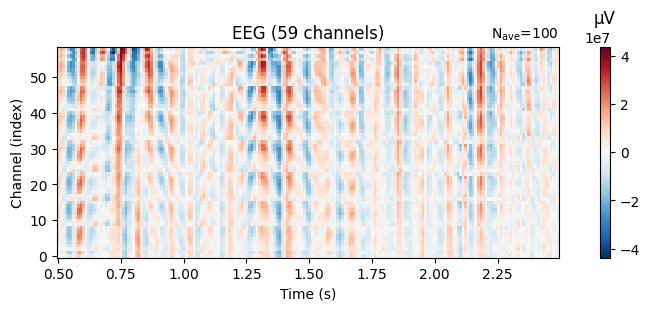

In [ ]:
epochs["foot"].average().plot_image()

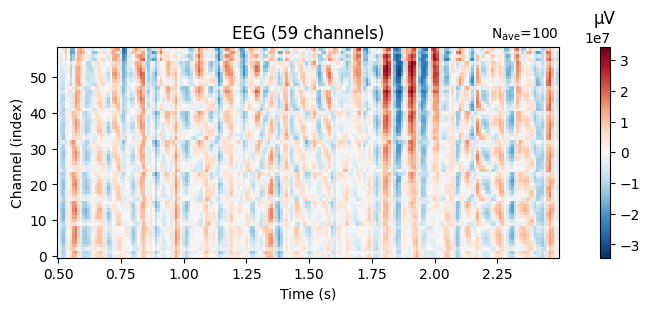

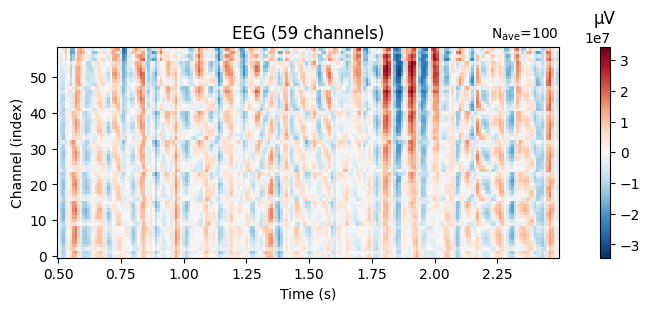

In [ ]:
epochs["left"].average().plot_image()

### topo maps
new

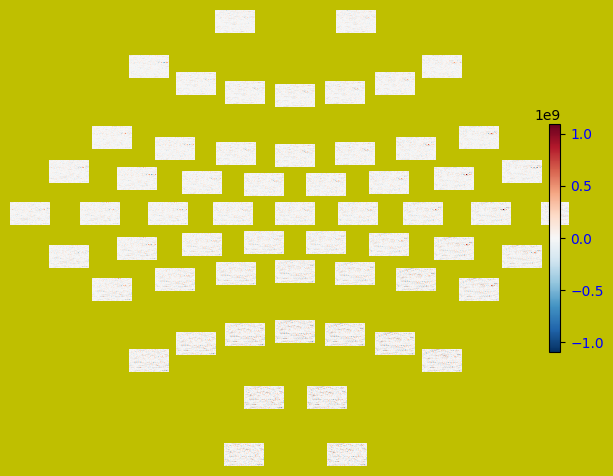

In [ ]:
epochs.plot_topo_image(layout=layout,
                       fig_facecolor='y', font_color='b');

### plotting events
new

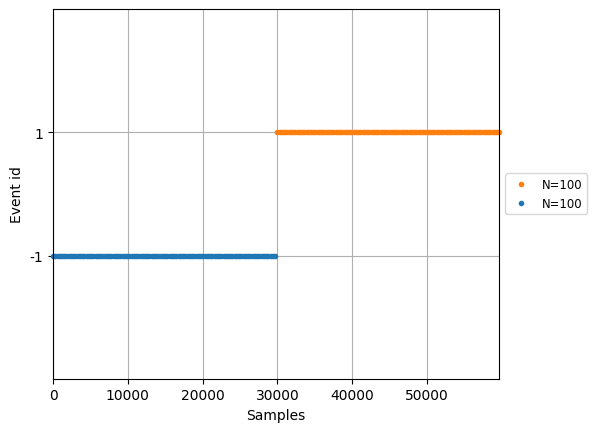

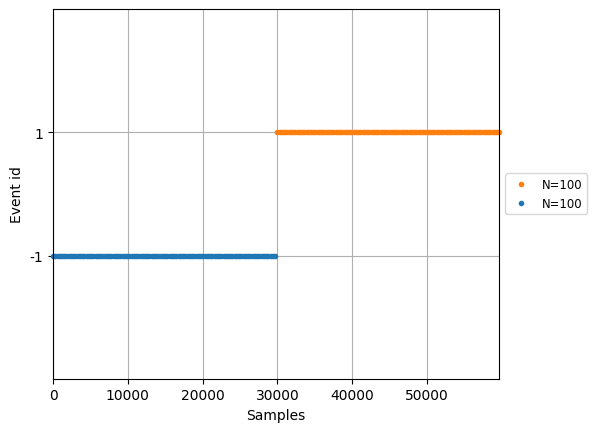

In [ ]:
mne.viz.plot_events(events[:200])

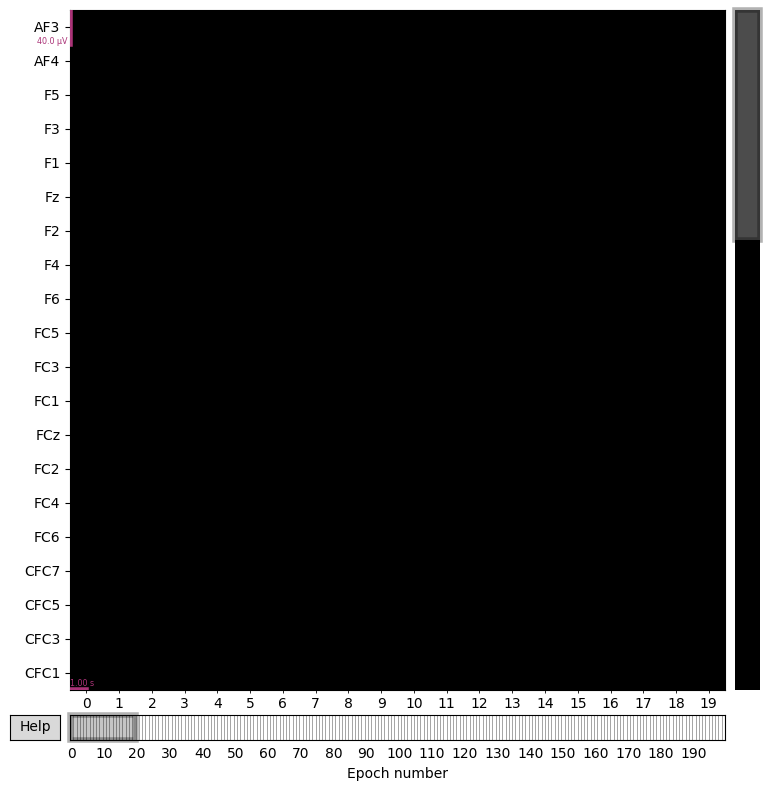

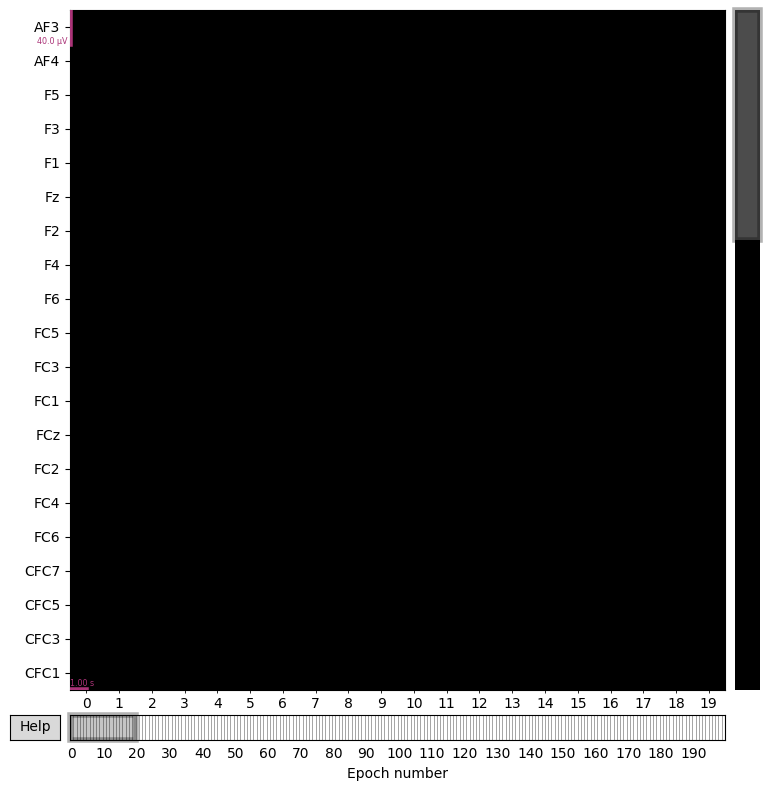

In [ ]:
epochs.plot()

### evoke

In [ ]:
lefti = epochs["left"].average()
lefti

Condition,left
Data kind,average
Timepoints,200 samples
Channels,59 channels
Number of averaged epochs,100
Time range (secs),0.5 – 2.49
Baseline (secs),off


In [ ]:
footi = epochs["foot"].average()
footi

Condition,foot
Data kind,average
Timepoints,200 samples
Channels,59 channels
Number of averaged epochs,100
Time range (secs),0.5 – 2.49
Baseline (secs),off


In [ ]:
combined_evoked = mne.combine_evoked([lefti, footi], weights='equal')

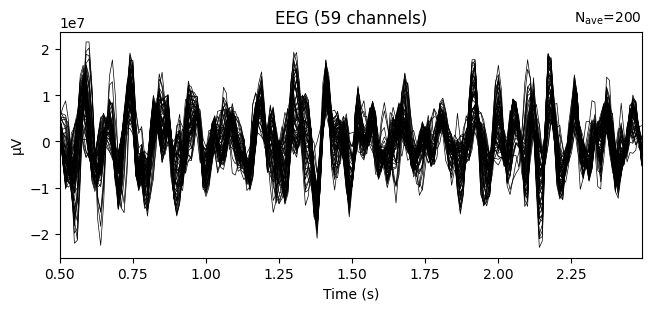

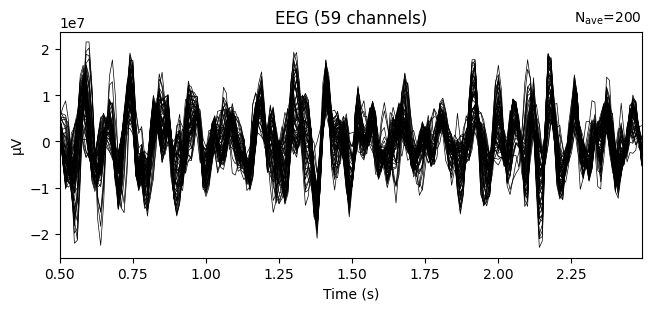

In [ ]:
combined_evoked.plot()

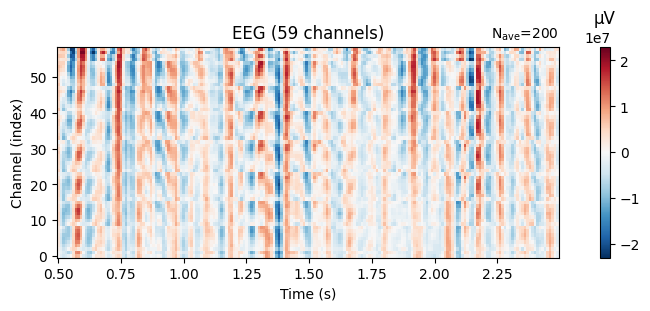

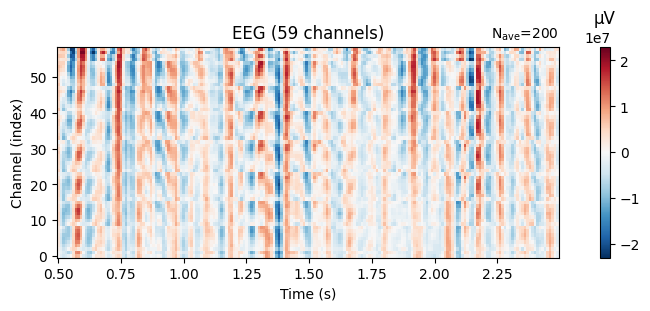

In [ ]:
combined_evoked.plot_image()

### oops, no digitization point found
new

No projector specified for this dataset. Please consider the method self.add_proj.


C:\Users\realv\AppData\Local\Temp\ipykernel_30956\1206636988.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  diff.plot_joint()


RuntimeError: No digitization points found.

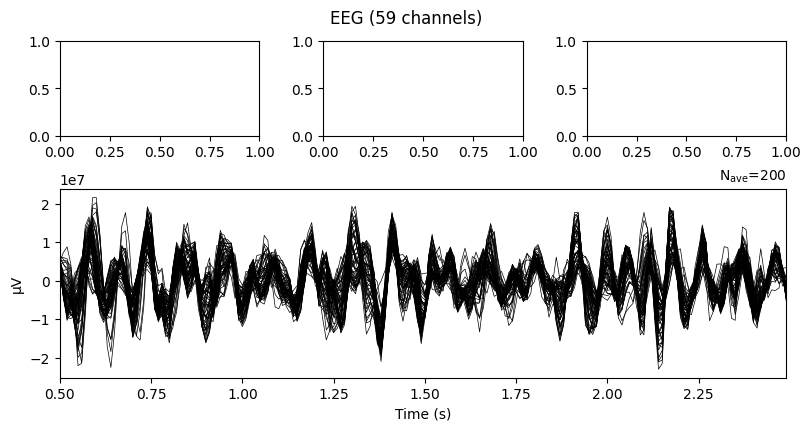

In [ ]:
diff = mne.combine_evoked((lefti, footi), weights='equal')
diff.plot_joint()